
This notebook is a supplement to the paper "A fundamental non-classical logic" (https://arxiv.org/abs/2207.06993) by Wesley H. Holliday (wesholliday@berkeley.edu). 

A longer, related notebook for the paper "Compatibility and accessibility: lattice representations for semantics of non-classical and modal logic" (https://arxiv.org/abs/2201.07098) is available at https://github.com/wesholliday/compat-frames. 

To view the notebook online, type the URL of this notebook (https://github.com/wesholliday/fundamental-logic/blob/main/relational-frames.ipynb) into the location field at https://nbviewer.org. GitHub's preview of the notebook does not show all the output that was generated.


# Notebook Outline

### I. [Drawing relational frames](#II)

### II. [Calculating fixpoints of the closure operator](#III)

### III. [Hasse diagrams of the fixpoint lattices](#IV)

### IV. [The $\neg_\vartriangleleft$ operation](#V)

### V. [Frames from Figures 11 and 12](#V)


### Preliminaries

In [231]:
from itertools import chain, combinations, product
import copy
import networkx as nx
import networkx.algorithms.isomorphism as iso
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from pprint import pprint
from tqdm.notebook import tqdm
from functools import partial

In [232]:
def powerset(iterable):
    """powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"""
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

## I. Drawing relational frames <a id='I'></a>

According to our convention in the paper, to represent the relational frame $(X,\vartriangleleft)$, we draw an arrow from $y$ to $x$ when $x\vartriangleleft y$. Thus, we draw the directed graph $(X,\vartriangleright)$ to represent the relational frame $(X,\vartriangleleft)$.

In [233]:
def domain(rel):
    """given a reflexive relation, returns the domain of the relation"""
    X = {pair[0] for pair in rel}
    
    return X

In [234]:
# when defining reflexive frames, 
# in order to avoid entering pairs (x,x) manually, we use the following:

def reflexive_closure(rel,X):
    """given a binary relation rel on X, returns the reflexive closure of rel"""
    relset = set(rel)

    for x in X:
        if not (x,x) in relset:
            rel.append((x,x))
    return rel

In [235]:
def draw_flipped_digraph(rel,X = None):
    """given a relation rel on X, draw the digraph for the inverse of rel;
    if no X is given, we assume rel is reflexive and take X to be the domain of rel"""
    
    if X is None:
        X = domain(rel)
    
    g = nx.DiGraph()
    g.add_nodes_from(X)
    
    for pair in rel:
        g.add_edge(pair[1],pair[0])
    
    nx.draw(g,with_labels=True)
    plt.show() 

## II. Calculating fixpoints of the closure operator <a id='II'></a>

In [236]:
def closure(A,rel,X = None):
    """given a subset A of X, returns the closure of A according to the closure operator
    c_rel defined in Prop. 4.3.1 of the paper from the given relation rel on X;
    if no X is given, we assume rel is reflexive and take X to be the domain of rel"""

    if X is None:
        X = domain(rel)
    
    Aset = set(A)
    Xset = set(X)
    closure = [x for x in A]
   
    for x in Xset - Aset:
        x_sees = {y for y in X if (y,x) in rel}
        seen_by_A = {z for z in X if any([pair[0]==z and pair[1] in Aset for pair in rel])}
        if x_sees.issubset(seen_by_A):
            closure.append(x)
        
    return closure

For small compatibility frames, we can simply check for each subset whether it is a fixpoint of the closure operator.

In [237]:
def fixpoints(rel,X = None):
    """given a binary relation rel on X, returns the fixpoints of c_rel according to Prop. 4.3.1 in the paper"""

    if X is None:
        X = domain(rel)
    
    fixpts = [(), tuple(X)]
    
    pwrset = powerset(X)

    for A in pwrset:
        if A == () or A == tuple(X):
            continue
            
        if A == tuple(closure(A,rel,X)):
            fixpts.append(A)

    return fixpts

To handle larger relational frames, we can use Ganter's algorithm to calculate fixpoints of a closure operator (Ganter B. (2010), "Two Basic Algorithms in Concept Analysis." In: Kwuida L., Sertkaya B. (eds) Formal Concept Analysis. ICFCA 2010. *Lecture Notes in Computer Science*, vol 5986. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-11928-6_22). 

Ganter's algorithm assumes a closure operator on the powerset of a set $X$ where $X$ is an initial segment of the natural numbers (or otherwise linearly ordered). Thus, we include a function to convert a given relational frame to an isomorphic copy whose domain is an initial segment of the natural numbers.

In [238]:
def convert_to_nums(rel, X = None):
    """Given a relational frame, return an isomorphic copy
    whose domain is an initial segment of the natural numbers plus
    a dictionary to go back from natural numbers to the original elements"""
    
    if X is None:
        X = domain(rel)
    
    forward_map = {}
    inverse_map = {}
    count = 0
    
    for x in X:
        forward_map[x] = count
        inverse_map[count] = x
        count += 1   
    
    newrel = []
    
    for pair in rel:
        newrel.append((forward_map[pair[0]],forward_map[pair[1]]))
    
    return newrel, inverse_map

We implement the algorithm on p. 316 of Ganter's paper with the following two functions.

In [239]:
def next_fixpoint(A, rel, X = None):
    """Given a relational frame rel on an initial segment of the natural numbers
    and a subset A, assumed to be a fixpoint, calculate the next fixpoint
    according to Ganter's lectic ordering"""
    
    if X is None:
        X = domain(rel)
        
    Aset = set(A)
    
    for i in reversed(X):
        if not i in Aset:
            iset = set(range(i))
            inter = Aset.intersection(iset)
            union = inter.union({i})
            Anext = closure(union, rel, X)
            if [j for j in Anext if j<i and not j in Aset] == []:
                return tuple(Anext)  

In [240]:
def Ganter_fixpoints(rel, X = None):
    """Given a relational frame rel, return the fixpoints according to Ganter's algorithm;
    if rel is not already on an initial segment of the natural numbers, 
    apply convert_to_nums in order to run next_fixpoint and then apply 
    the inverse map to get corresponding fixpoints for the original rel"""
    
    if X is None:
        X = domain(rel)
        
    if tuple(X) == tuple(range(len(X))):
        
        setX = set(X)
        listX = list(X)
    
        fixpts = [()]
        A = ()
    
        while not set(A) == setX:
            A_next = next_fixpoint(A,rel,listX)
            A = A_next
            fixpts.append(A_next)
        
        return fixpts
    
    else:
        conv = convert_to_nums(rel, X)
        newrel = conv[0]
        inverse = conv[1]
        newX = domain(newrel)
        
        setX = set(newX)
        listX = list(newX)
        
        fixpts = [()]
        A = ()
    
        while not set(A) == setX:
            A_next = next_fixpoint(A,newrel,listX)
            A = A_next
            A_next_inverse = tuple({inverse[a] for a in A_next})
            fixpts.append(A_next_inverse)
        
        return fixpts

Fig. 1, left:


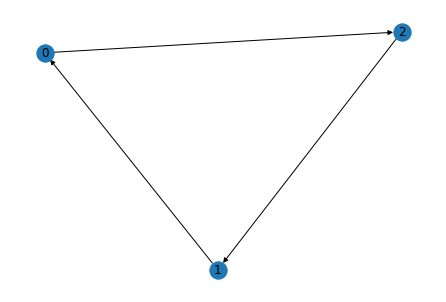

relational frame: [(0, 1), (1, 2), (2, 0), (0, 0), (1, 1), (2, 2)]
fixpoints: [(), (0, 1, 2), (0,), (1,), (2,)]


Fig. 1, right:


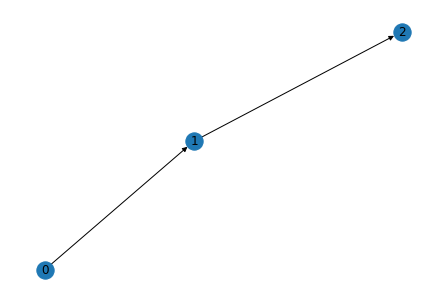

relational frame: [(1, 0), (2, 1), (0, 0), (1, 1), (2, 2)]
fixpoints: [(), (0, 1, 2), (0,), (2,), (1, 2)]


Fig. 2:


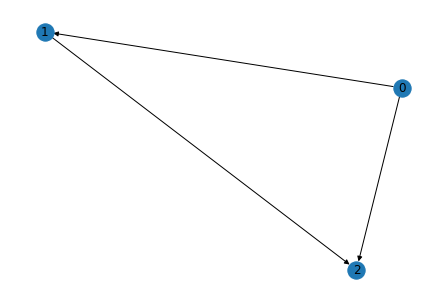

relational frame: [(1, 0), (2, 1), (2, 0), (0, 0), (1, 1), (2, 2)]
fixpoints: [(), (0, 1, 2), (2,), (1, 2)]


Fig. 3, left:


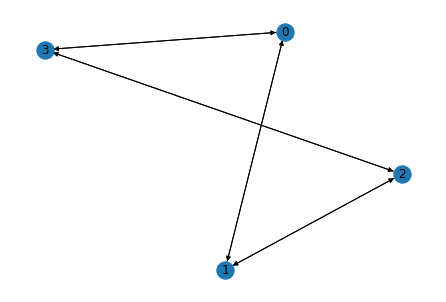

relational frame: [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (3, 0), (0, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
fixpoints: [(), (0, 1, 2, 3), (0,), (1,), (2,), (3,)]


Fig. 3, right:


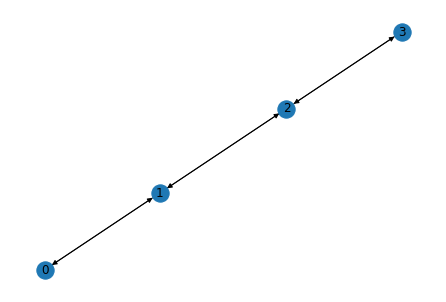

relational frame: [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 0), (1, 1), (2, 2), (3, 3)]
fixpoints: [(), (0, 1, 2, 3), (0,), (3,), (0, 1), (2, 3)]


Fig. 6:


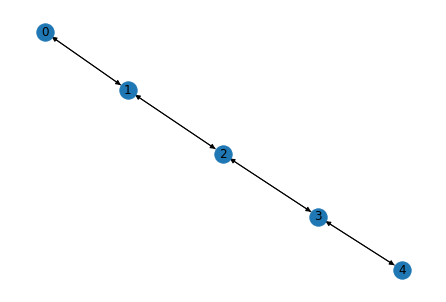

relational frame: [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (3, 4), (4, 3), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
fixpoints: [(), (0, 1, 2, 3, 4), (0,), (2,), (4,), (0, 1), (0, 4), (3, 4), (0, 1, 2), (2, 3, 4)]


Fig. A.1:


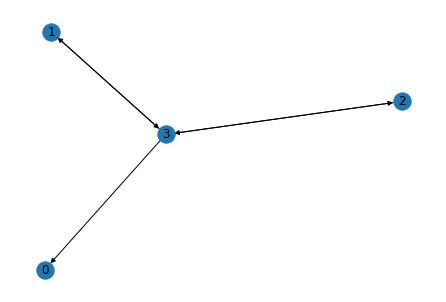

relational frame: [(0, 3), (1, 3), (3, 1), (2, 3), (3, 2), (0, 0), (1, 1), (2, 2), (3, 3)]
fixpoints: [(), (0, 1, 2, 3), (0,), (1,), (2,), (0, 1), (0, 2), (1, 2)]


Another example not in the paper:


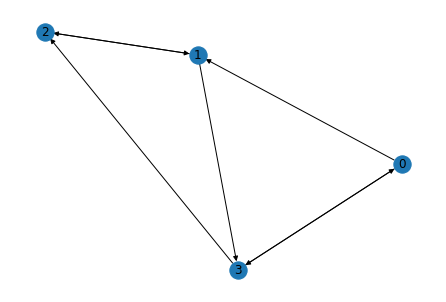

relational frame: [(1, 0), (1, 2), (2, 1), (0, 3), (3, 0), (3, 1), (2, 3), (0, 0), (1, 1), (2, 2), (3, 3)]
fixpoints: [(), (0, 1, 2, 3), (0,), (2,), (3,), (1, 2)]




In [241]:
# Below are examples from the paper 
# "Compatibility and accessibility: lattice representations for semantics of non-classical and modal logics"

exs = {0: ("Fig. 1, left:",reflexive_closure([(0,1),(1,2),(2,0)],range(3))), 
       1: ("Fig. 1, right:",reflexive_closure([(1,0),(2,1)],range(3))),
       2: ("Fig. 2:",reflexive_closure([(1,0),(2,1),(2,0)],range(3))),
       3: ("Fig. 3, left:",reflexive_closure([(0,1),(1,0),(1,2),(2,1),(2,3),(3,2),(3,0),(0,3)],range(4))),
       4: ("Fig. 3, right:",reflexive_closure([(0,1),(1,0),(1,2),(2,1),(2,3),(3,2)],range(4))),
       5: ("Fig. 6:",reflexive_closure([(0,1),(1,0), (1,2), (2,1), (2,3), (3,2),(3,4),(4,3)],range(5))),
       6: ("Fig. A.1:",reflexive_closure([(0,3), (1,3), (3,1), (2,3), (3,2)],range(4))),
       7: ("Another example not in the paper:",reflexive_closure([(1,0),(1,2),(2,1),(0,3),(3,0),(3,1),(2,3)],range(4)))
      }
   
for i in range(8):
    print(exs.get(i)[0])
    draw_flipped_digraph(exs.get(i)[1])
    print(f"relational frame: {exs.get(i)[1]}")
    print(f"fixpoints: {fixpoints(exs.get(i)[1])}")
    print("\n")
    
# saving the last example for later:

example_rel = reflexive_closure([(1,0),(1,2),(2,1),(0,3),(3,0),(3,1),(2,3)],range(4))
example_fixpts = fixpoints(example_rel)

## III. Hasse diagrams of the fixpoint lattices <a id='III'></a>

Given a family of fixpoints, we first calculate the proper subset relation between fixpoints, then calculate the associated covering relation, and finally create a networkx digraph for the Hasse diagram of the fixpoint lattice.

In [242]:
def propsubrel(lt):
    """given a list of tuples representing a set of sets, returns the proper subset relation as a list of pairs"""
    propsubrel = []
    
    for A in lt:
        for B in lt:  
            if set(A).issubset(set(B)) and not set(B).issubset(set(A)):
                propsubrel.append((A,B))
                
    return propsubrel

In [243]:
print(propsubrel(example_fixpts))

[((), (0, 1, 2, 3)), ((), (0,)), ((), (2,)), ((), (3,)), ((), (1, 2)), ((0,), (0, 1, 2, 3)), ((2,), (0, 1, 2, 3)), ((2,), (1, 2)), ((3,), (0, 1, 2, 3)), ((1, 2), (0, 1, 2, 3))]


In [244]:
def covering(spo):
    """given a strict partial order spo, returns the associated covering relation"""
    cover = copy.deepcopy(spo)
    for p1 in spo:
        for p2 in spo:
            if p1 in cover and p1[0] == p2[0] and (p2[1],p1[1]) in spo:
                cover.remove(p1)
                break
    return cover

In [245]:
print(covering(propsubrel(example_fixpts)))

[((), (0,)), ((), (2,)), ((), (3,)), ((0,), (0, 1, 2, 3)), ((2,), (1, 2)), ((3,), (0, 1, 2, 3)), ((1, 2), (0, 1, 2, 3))]


In [246]:
def lattice(rel,X = None):
    """given a relation rel on X, returns the Hasse diagram of the lattice of fixpoints"""
    
    if X is None:
        X = set([pair[0] for pair in rel]) 
        
    fix = fixpoints(rel,X)
    cover = covering(propsubrel(fix))
    l = nx.DiGraph()
    l.add_nodes_from(fix)
    l.add_edges_from(cover) 
    
    return l

Since we use graphviz dot to display the lattices, and graphviz dot draws arrows going down, an arrow from $y$ down to $x$ means that $x\leq y$ in our lattice.

In [247]:
def display_lattice(l):
    
    lrev = nx.DiGraph.reverse(l) 
    # We reverse the lattice arrows because graphviz draws all arrows going down, 
    # so if we did not do this, the top element of the lattice would appear at the bottom
    
    pos = graphviz_layout(lrev, prog="dot")
    nx.draw(lrev, pos, with_labels=True, arrowsize=15)
    plt.show() 

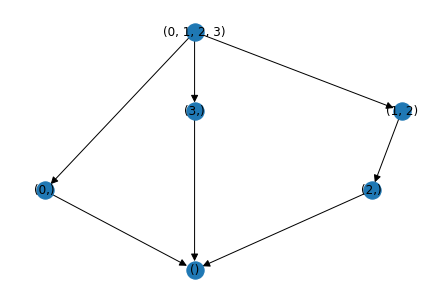

In [248]:
l = lattice(example_rel)

display_lattice(l)

## IV. The $\neg_\vartriangleleft$ operation  <a id='I.VI'></a>

In this section, we compute the $\neg_\vartriangleleft$ operation on fixpoints from Proposition 4.3.2 in the paper.

In [249]:
def neg_pairs(rel, X = None):
    """given a relation rel on X, return a set of pairs of fixpoints representing the neg function on fixpoints
    as in Proposition 4.3.2 in the paper"""
    
    if X is None:
        X = domain(rel)
        
    fixpts = fixpoints(rel,X)
    
    negrel = []
    
    for A in fixpts:
        Aset = set(A)
        negA = tuple({x for x in X if not any([pair[1]==x and pair[0] in Aset for pair in rel])})
        negrel.append((A,negA))
    
    return negrel

In [250]:
# An example
rel = reflexive_closure([(0,1),(1,2),(2,0)],range(3))
neg_pairs(rel)

[((), (0, 1, 2)), ((0, 1, 2), ()), ((0,), (2,)), ((1,), (0,)), ((2,), (1,))]

In [251]:
def neg_dict(rel, X = None):
    """Like the neg function but returns a dictionary instead of a set of pairs"""
    
    if X is None:
        X = domain(rel)
        
    fixpts = fixpoints(rel,X)
    
    negd = {}
    
    for A in fixpts:
        Aset = set(A)
        negA = tuple({x for x in X if not any([pair[1]==x and pair[0] in Aset for pair in rel])})
        negd[A] = negA
    
    return negd

In [252]:
def lattice_with_neg(rel, X = None):
    """given a relation rel on X, return the Hasse diagram of the lattice of fixpoints plus the negation operation"""
    
    if X is None:
        X = domain(rel)
        
    fix = fixpoints(rel,X)
    cover = covering(propsubrel(fix))
    negrel = neg_pairs(rel,X)
    
    l = nx.MultiDiGraph()
    l.add_nodes_from(fix)
    l.add_edges_from(cover, weight=0) # use weight to distinguish between the covering relation and neg operation
    l.add_edges_from(negrel, weight=1) # use weight to distinguish between the covering relation and neg operation
    
    return l

In [253]:
def display_lattice_with_neg(l):
    """given the Hasse diagram of a lattice with neg operation, 
    draw covering relation with solid arrows and neg operation with dashed arrows"""

    coveredges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==0]
    negedges = [(x,y) for (x,y,d) in l.edges(data=True) if d["weight"]==1]

    lat = nx.DiGraph()
    lat.add_nodes_from(l.nodes)
    lat.add_edges_from(coveredges) 

    latrev = nx.DiGraph.reverse(lat) 
    # We reverse the lattice arrows because graphviz draws all arrows going down, 
    # so if we did not do this, the top element of the lattice would appear at the bottom
    
    pos = graphviz_layout(latrev, prog="dot")
    nx.draw_networkx_nodes(latrev,pos)
    nx.draw_networkx_labels(latrev,pos,alpha=.75)
    nx.draw_networkx_edges(latrev,pos,arrowsize=15)
    nx.draw_networkx_edges(l, pos, arrowsize=15, edgelist=negedges,edge_color='r', style="dashed",connectionstyle="arc3,rad=0.2")
    
    plt.show() 

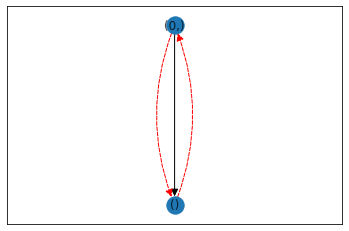

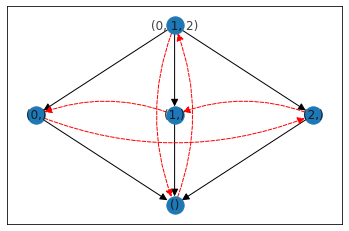

In [254]:
# Examples

l = lattice_with_neg(reflexive_closure([],[0]))

display_lattice_with_neg(l)

l = lattice_with_neg(reflexive_closure([(0,1),(1,2),(2,0)],range(3)))

display_lattice_with_neg(l)


# V. Frames from Figures 11 and 12

In [255]:
def pseudosymmetric(rel, X=None):
    """Determine whether the binary relation rel is pseudosymmetric 
    as in Proposition 4.12.2(b) of the paper"""

    if X is None:
        X = domain(rel)

    ps = True

    for x in X:
        for y in X:
            if (y,x) in rel:
                found_witness = False
                for z in X:
                    if (z,y) in rel and {w for w in X if (w,z) in rel }.issubset({w for w in X if (w,x) in rel}):
                        found_witness = True
                
                if found_witness == False:
                    ps = False
                    return ps

    return ps


In [256]:
def strongly_pseudosymmetric(rel, X=None):
    """Determine whether the binary relation rel is pseudosymmetric 
    as in Definition 4.15 of the paper"""

    if X is None:
        X = domain(rel)

    ps = True

    for x in X:
        for y in X:
            if (y,x) in rel:
                found_witness = False
                for z in X:
                    if (z,y) in rel and {w for w in X if (w,z) in rel } == {w for w in X if (w,x) in rel}:
                        found_witness = True
                
                if found_witness == False:
                    ps = False
                    return ps

    return ps

## Figure 11, left

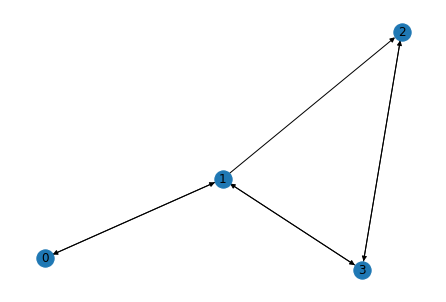

In [257]:
fig11left = reflexive_closure([(0,1), (1,0), (2,1), (1,3), (3,1), (2,3), (3,2)], range(4))

draw_flipped_digraph(fig11left)

In [258]:
pseudosymmetric(fig11left)

True

In [259]:
strongly_pseudosymmetric(fig11left)

False

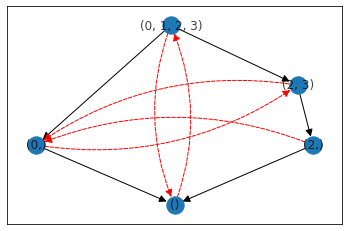

In [260]:
l = lattice_with_neg(fig11left)

display_lattice_with_neg(l)

## Figure 11, middle

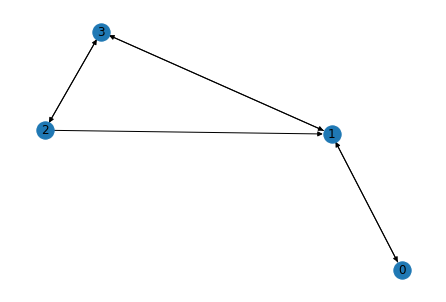

In [261]:
fig11mid = reflexive_closure([(0,1), (1,0), (1,2), (1,3), (3,1), (2,3), (3,2)], range(4))

draw_flipped_digraph(fig11mid)

In [262]:
strongly_pseudosymmetric(fig11mid)

True

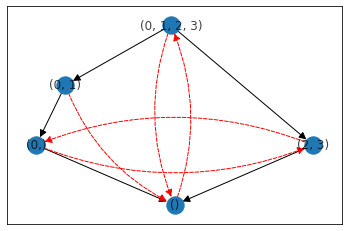

In [263]:
l = lattice_with_neg(fig11mid)

display_lattice_with_neg(l)

## Figure 11, right

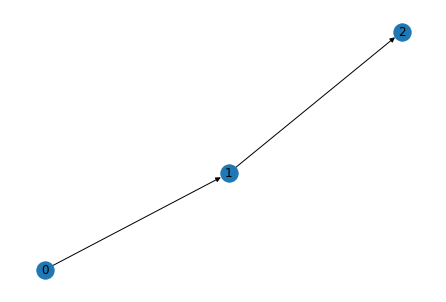

In [264]:
fig11right = reflexive_closure([(1,0), (2,1)], range(3))

draw_flipped_digraph(fig11right)

In [265]:
strongly_pseudosymmetric(fig11right)

False

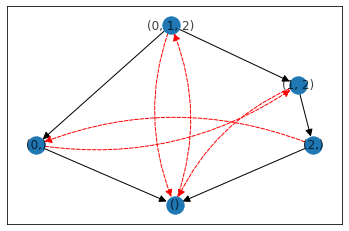

In [266]:
l = lattice_with_neg(fig11right)

display_lattice_with_neg(l)

## Figure 12, left

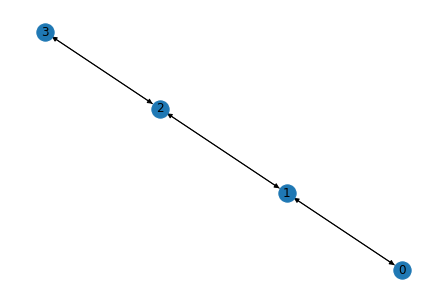

In [267]:
fig12left = reflexive_closure([(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)],range(4))

draw_flipped_digraph(fig12left)

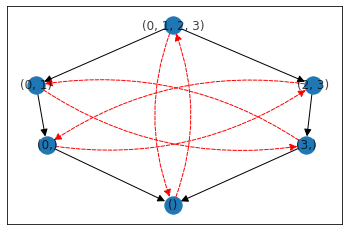

In [268]:
l = lattice_with_neg(fig12left)

display_lattice_with_neg(l)

## Figure 12, right

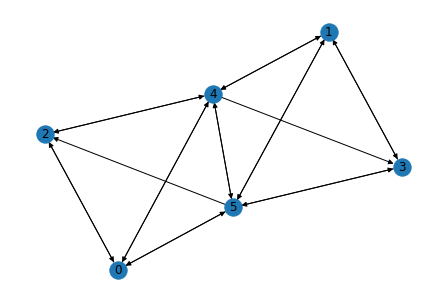

In [269]:
fig12right = [(0, 2), (2, 0), (0, 4), (4, 0), (0, 5), (5, 0), (1, 3), (3, 1), (1, 4), (4, 1), (1, 5), (5, 1), (2, 4), (4, 2), (2, 5), (3, 4), (3, 5), (5, 3), (4, 5), (5, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]

draw_flipped_digraph(fig12right)

In [270]:
strongly_pseudosymmetric(fig12right)

True

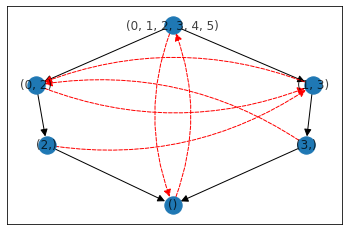

In [271]:
l = lattice_with_neg(fig12right)

display_lattice_with_neg(l)